# Notebook contents: 

This notebook contains a lecture. The code for generating plots are found at the of the notebook. Links below.

- [presentation](#Session-1b:)
- [code for plots](#Code-for-plots)

# Session 13:
## Supervised learning, part 2

*Andreas Bjerre-Nielsen*

## Agenda
1. [model building](#Model-building) 
1. [model selection](#Model-selection) 
  - [cross validation](#Cross-validation)
  - [tools for selection](#Tools-for-model-selection)


## Vaaaamos

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns


# Recap from yesterday
Stuff about machine learning
- 
- 
- 
- 
- 

## Supervised problems (1)
*What is the tradeoff for making supervised regression models?*

In [2]:
f_bias_var['regression'][2]

NameError: name 'f_bias_var' is not defined

## Supervised problems (2)
*What was a remedy to overfitting in linear models? How do we measure overfitting?*

Regularization
- Too many irrelevant features - solved by L1 regularization ~ lasso
- Exploding coefficients - solved by L2 regularization ~ ridge

# Model building 

## Model pipelines (1)
*Is there a smart way to build ML models?*

Yes, we build a pipeline:
- From input (tidy) -> output
- Preprocessing data
    - Standard: adding polynomials, imputation, rescaling
    - Unsupervised learning (not this course)
- Supervised learning

## Model pipelines (2)
*How does the pipeline look? Is there data leakage?*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_01.png' alt="Drawing" style="width: 800px;"/></center>


## Model pipelines (3)
*What are the advantages of using a pipeline?*

- Ensures good practice - we only fit on training data. 
    - No leakage of data from train to test!
- Much less code!

## Applying a model pipeline (1)
*What would this look like in Python?*

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipe_preproc = make_pipeline(PolynomialFeatures(), 
                             StandardScaler())

print(pipe_preproc.steps[0])
print(pipe_preproc.steps[1])

('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C'))
('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))


## Applying a model pipeline (2)
*Does this remind you of something?*

# YES!

### Method chaining from Pandas

## Applying a model pipeline (3)
*Let's some load Boston house price data*

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
# print(boston['DESCR'])
# print('\n'.join(load_boston()['DESCR'].split('\n')[12:26]))
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Applying a model pipeline (4)
*And how do I apply the pipe on the data?*

In [5]:
pipe_preproc = make_pipeline(PolynomialFeatures(), 
                             StandardScaler()) # apply preproc - fit on train

X_train_prep = pipe_preproc.fit_transform(X_train) # transform training data
X_test_prep = pipe_preproc.transform(X_test) # transform test data

## Applying a model pipeline (5)
*What would it like look if we did use the pipe..?*

The more steps we have, the more code we save.

In [6]:
poly_trans = PolynomialFeatures()
scaler = StandardScaler()

# we call both transformations twice on both test and train
X_train_poly = poly_trans.fit_transform(X_train) 
X_test_poly = poly_trans.transform(X_test)

X_train_prep_alt = scaler.fit_transform(X_train_poly)
X_test_prep_alt = scaler.transform(X_test_poly)

# Model selection 


## Measuring the problem
*Does machine learning work out of the box?*

- In some cases ML works quite well out of the box.
- Often ML requires making careful choices.
    - Note that automated machine learning packages and services exist.
    - E.g. AutoML - this a hot research topic

*Which choices are to be made?*

- We need to pick model building **hyperparameters**.
- E.g. $\lambda$ for Lasso, Ridge.

## Model validation (1)
*How do we measure our model's performance for different hyperparameters?*

- Remember we cannot use the test set.

*Could we somehow mimick what we do with test data?*

- Yes, we can split the remaining non-test data into training and validation data:
    - we train model for various hyperparameters on training data;
    - pick the hyperparameters which performs best on validation data.

## Model validation (2)
*The non-test data is split into training and validation*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_02.png' alt="Drawing" style="width: 800px;"/></center>


## Model validation (3)
*What would this look like in Python?*

In [16]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

## Model validation (4)
Let's train a linear regression model

In [8]:
from sklearn.linear_model import Lasso, LinearRegression
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Model validation (5)
Let's find the  Lasso model which performs best in the validation set

In [9]:
from sklearn.metrics import mean_squared_error as mse

perform = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)

optimal = hyperparam_perform.nsmallest(1)    
print('Optimal alpha:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal alpha: 0.01
Validation MSE: 18.421


[1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02 1.77827941e+02 3.16227766e+02 5.62341325e+02
 1.00000000e+03 1.77827941e+03 3.16227766e+03 5.62341325e+03
 1.00000000e+04]


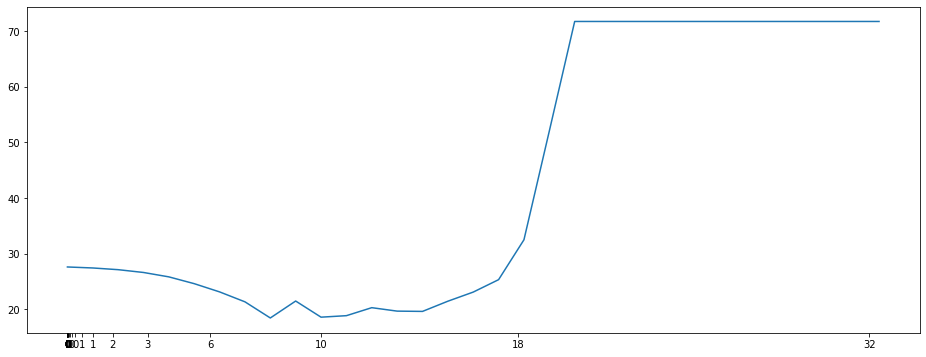

In [10]:
plt.figure(figsize=(16,6))
print(lambdas)
plt.xticks(lambdas)
ax = sns.lineplot(x=range(len(lambdas)), y=hyperparam_perform)
# sns.lineplot(x=range(len(perform)), y=perform)

# ax.set(xscale="log")

## Model validation (6)
Let's compare the performance of the Lasso vs. Linear Regression

In [11]:
# Insert optimal lambda into model
pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# Development data, non test
pipe_lasso.fit(X_dev,y_dev)
# Compare performance on test data
print('Lasso', round(mse(pipe_lasso.predict(X_test),y_test), 3)) # L1 regularization
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 3))

Lasso 12.399
LinReg 17.802


## Bias and variance (1)
*How do we describe the modelling error?*

From [Wikipedia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) yesterday:

- model **bias**: _an error from erroneous assumptions in the learning algorithm_
  - high bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)
   

- model **variance**: _an error from sensitivity to small fluctuations in the training set_
  -  high variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**).
 

## Bias and variance (2)
*So what is overfitting?*

Overfitting is: low bias / high variance

- traning our model captures all patterns but we also find some irrelevant
- reacts too much to training sample errors 
    - some errors are just noise, and thus we find too many spurious relations 
- examples of causes: 
    - too much polynomial expansion of variables (`PolynomialFeatures`)
    - non-linear/logistic without properly tuned hyperparameters: 
        - Decision Trees, Support Vector Machines or Neural Networks

## Bias and variance (3)
*So what is underfitting?*

Underfitting is: high bias / low variance
- oversimplification of models, cannot approximate all patterns found
- examples of causes: 
    - linear and logistic regression (without polynomial expansion)

## Bias and variance (4)
*Not so fast.. OLS is unbiased, right?*

Yes, OLS is unbiased. But...?

- But .. only by assumption..
    - Requires we know the true form of the model. 
        - However, we never know do..

*What happens if we introduce regularization?*
- Then model is no longer unbiased.
    - (if we assume the model is true)

## Smarter validation
*Is this approach the smartest way for deciding on choice of hyperparameters?*

# NO


Our model choice depends a lot on which sample we pick. Could we use more of the data?

# Cross validation


## The holdout method
*How do we got the more out of the data?*

We reuse the data in the development set repeatedly
- We test on all the data
- Rotate which parts of data is used for test and train.

## Leave-one-out CV
*How do we got the most of the data?*

The most robust approach
- Each single observation in the training data we use the remaining data to train.
- Makes number of models equal to the number of observations
- Very computing intensive - does not scale!
LOOCV

## K fold method (1)
*How do balance computing time vs. overfitting?*

We split the sample into $K$ even sized test bins.
- For each test bin $k$ we use the remaining data for training.

Advantages:
- We use all our data for testing.
- Training is done with 100-(100/K) pct. of the data, i.e. 90 pct. for K=10.

## K fold method (2)
In K-fold cross validation we average the errors.

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_03.png' alt="Drawing" style="width: 1100px;"/></center>

## K fold method (3)
*How would we use K-fold cross validation to select our model?*

We compute MSE for every lambda and every fold (nested for loop)

In [12]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)

# outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    # inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train, = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # store result    
    mseCV.append(mseCV_) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

In [14]:
lambdaCV.mean(axis=1)

0.000100        31.425083
0.000178        30.112652
0.000316        28.948846
0.000562        27.701719
0.001000        25.425413
0.001778        21.452986
0.003162        16.833624
0.005623        15.379743
0.010000        15.186852
0.017783        15.370488
0.031623        16.635102
0.056234        17.798497
0.100000        17.429708
0.177828        18.690404
0.316228        20.968687
0.562341        22.358850
1.000000        24.872261
1.778279        28.022814
3.162278        37.661228
5.623413        67.138740
10.000000       83.665706
17.782794       83.665706
31.622777       83.665706
56.234133       83.665706
100.000000      83.665706
177.827941      83.665706
316.227766      83.665706
562.341325      83.665706
1000.000000     83.665706
1778.279410     83.665706
3162.277660     83.665706
5623.413252     83.665706
10000.000000    83.665706
dtype: float64

# K fold method (4)
Training the model with optimal hyperparameters and compare MSE

In [15]:
# choose optimal hyperparameters 
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)

# retrain model using optimal hyperparameters
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=1))
pipe_lassoCV.fit(X_dev,y_dev)

# compare performance
models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 2))

Lasso 12.4
Lasso CV 12.4
LinReg 17.8


## K fold method (5)
*What else could we use cross-validation for?*

- Getting more evaluations of our model performance.
- We can cross validate at two levels:
    - Outer: we make multiple splits of test and train/dev.
    - Inner: within each train/dev. dataset we make cross validation to choose hyperparameters

## Learning curves (1)
*What does a balanced model look like?*

<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_04.png' alt="Drawing" style="width: 800px;"/></center>

## Learning curves (2)

In [47]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                 Train       Test
sample size                      
40           75.581181  90.927863
50           67.976177  87.452863
60           62.018394  87.214540


## Learning curves (3)

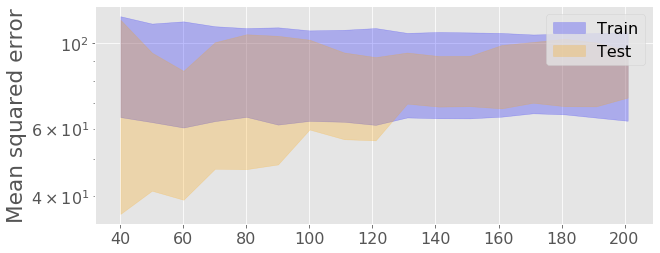

In [48]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Train', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Test', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

## Learning curves (4)

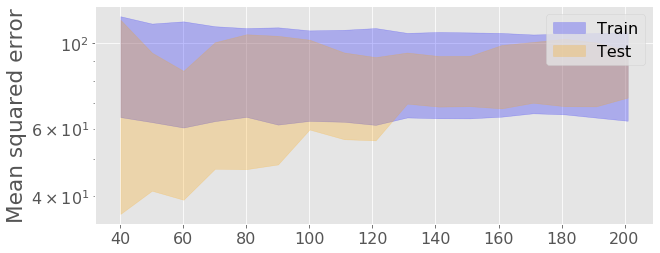

In [49]:
f_learn

# Tools for model selection

## Validation curves (1)

In [50]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda') 
print(mse_score.Validation.nsmallest(1))

lambda
0.017783    17.207944
Name: Validation, dtype: float64


## Validation curves (2)

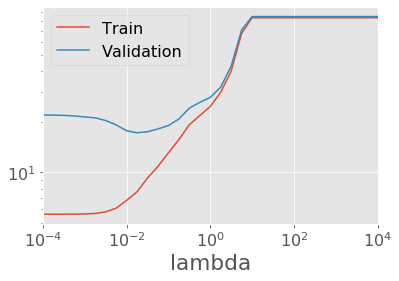

In [51]:
mse_score.plot(logx=True, logy=True)

## Grid search (1)
*How do we search for two or more optimal parameters? (e.g. elastic net)*

- Goal: find the optimal parameter combination: $$\lambda_1^*,\lambda_2^*=\arg\min_{\lambda_1,\lambda_2}MSE^{CV}(X_{train},y_{train})$$

- Option 1: We can loop over the joint grid of parameters.
  - One level for each parameter.
  - Caveats:

- Option 2: sklearn has `GridSearchCV` has a tool which tests all parameter combinations.

## Grid search (2)
*How does this look in Python?*

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
pipe_el = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        ElasticNet())
gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':np.logspace(-4,4,10)*2,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                  scoring='neg_mean_squared_error', 
                  n_jobs=4,
                  iid=False,
                  cv=10)

- Notation: double underscore between estimator and hyperparameter, e.g. 'est__hyperparam' 
- Scoring: negative MSE as we're maximizing the score ~ minimize MSE.

## Grid search (3)
*What does the grid search yield?*

In [ ]:
models['ElasicNetCV'] = gs.fit(X_train, y_train)
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 2))
print()
print('CV params:', gs.best_params_)

## Grid search (4)
*What if we have 10,000 parameter combinations?*

- Option 1: you buy a cluster on Amazon, learn how to parallelize across computers. 

- Option 2: you drop some of the parameter values

- Option 3: `RandomizedSearchCV` searches a subset of the combinations.

# The end
[Return to agenda](#Agenda)

# Code for plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

### Plots of ML types

/home/mian/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


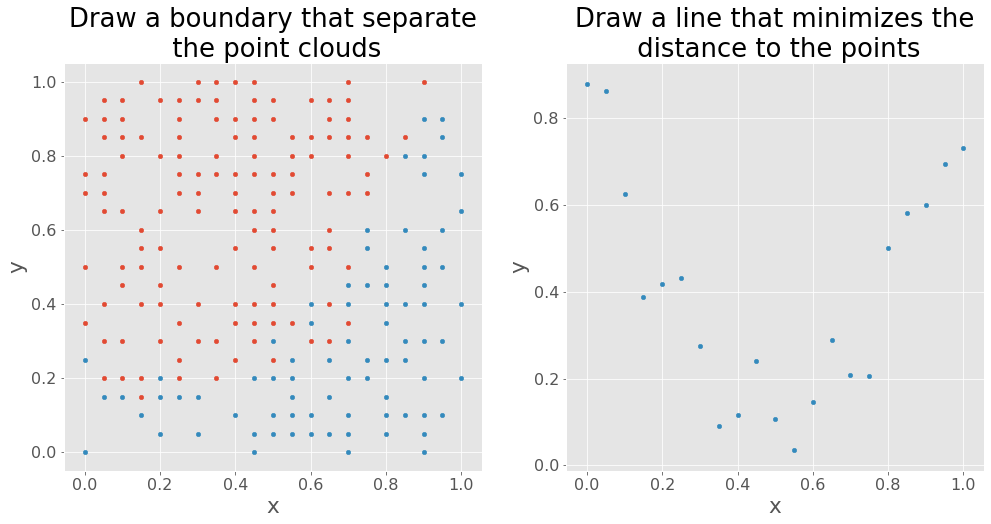

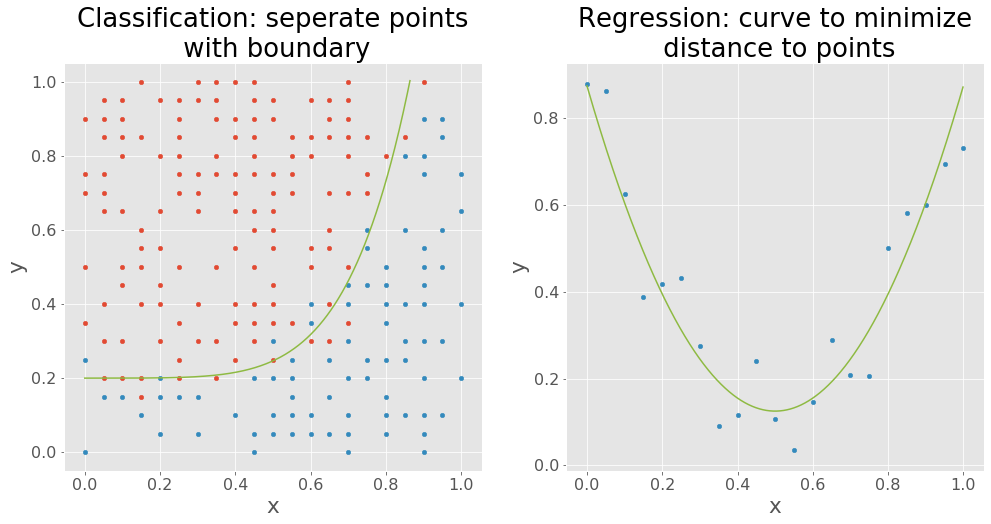

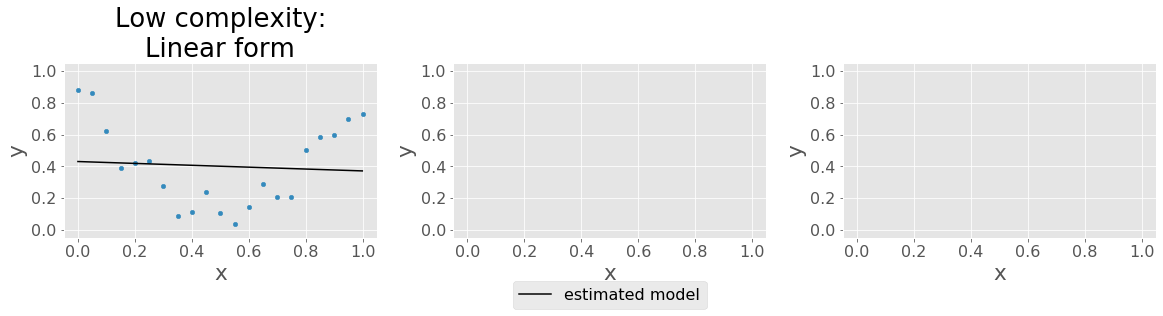

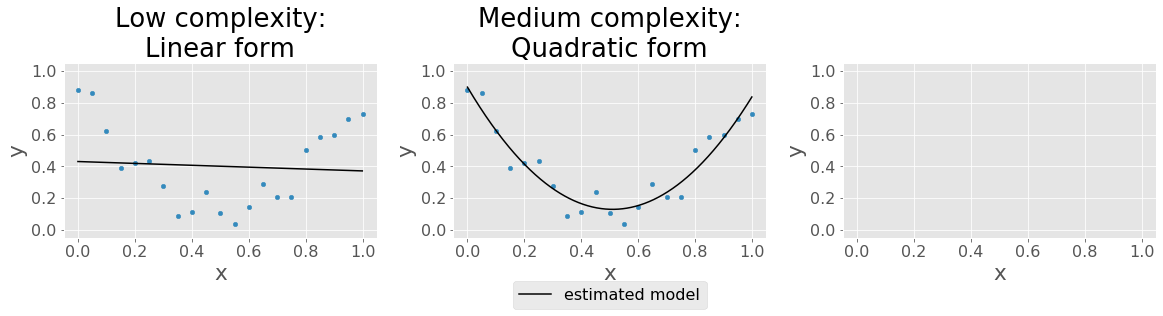

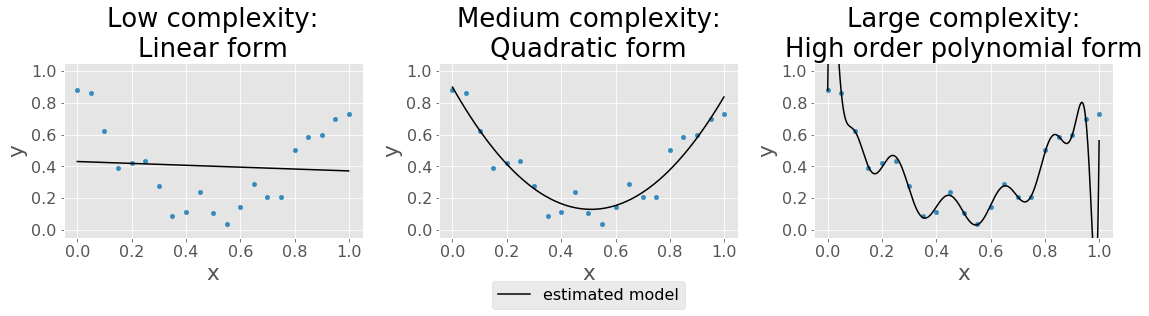

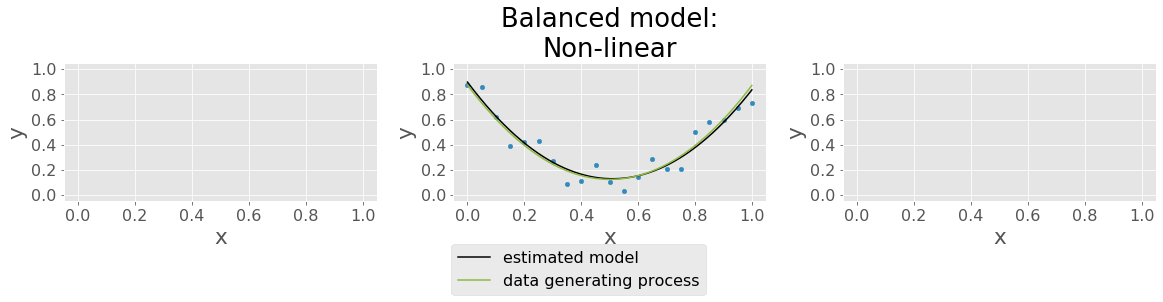

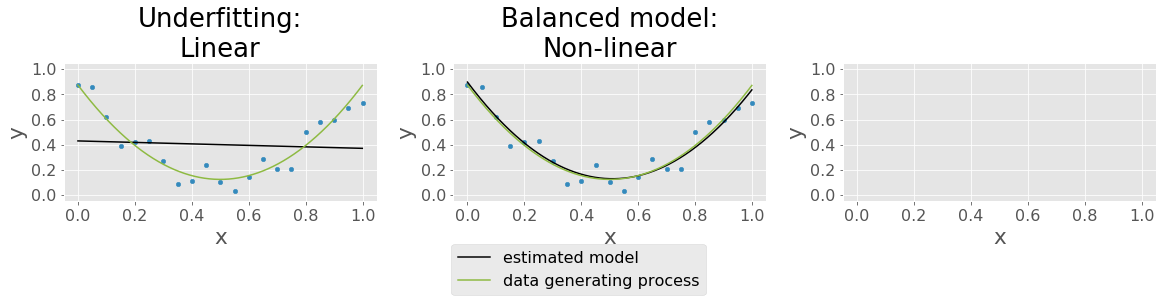

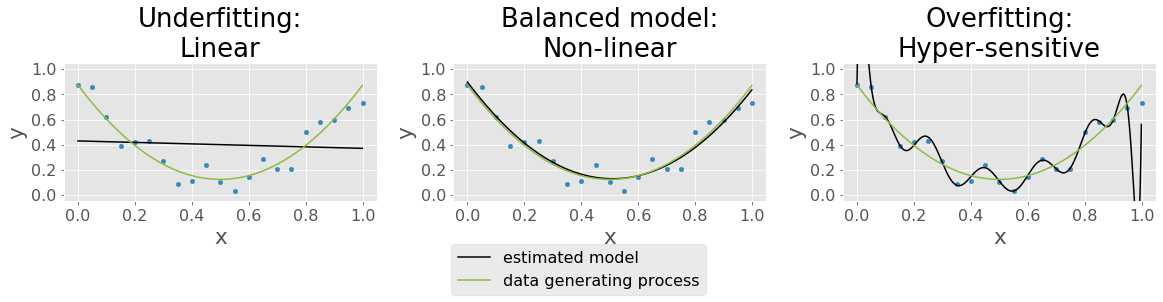

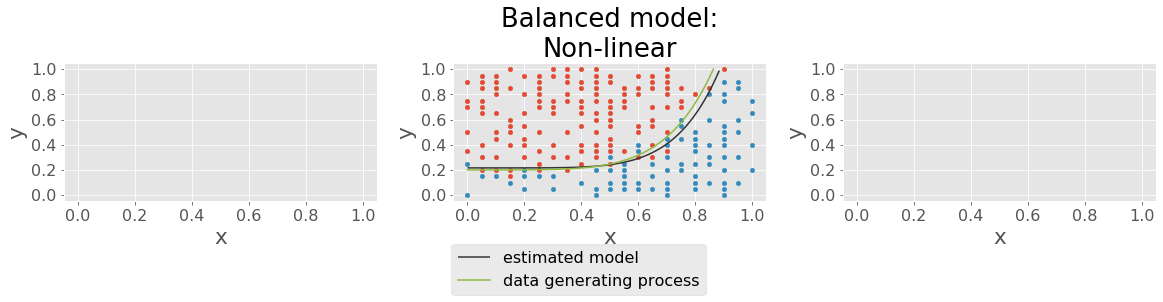

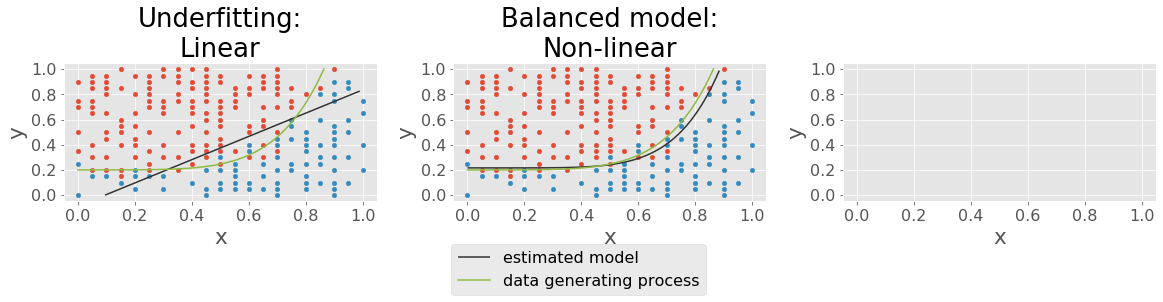

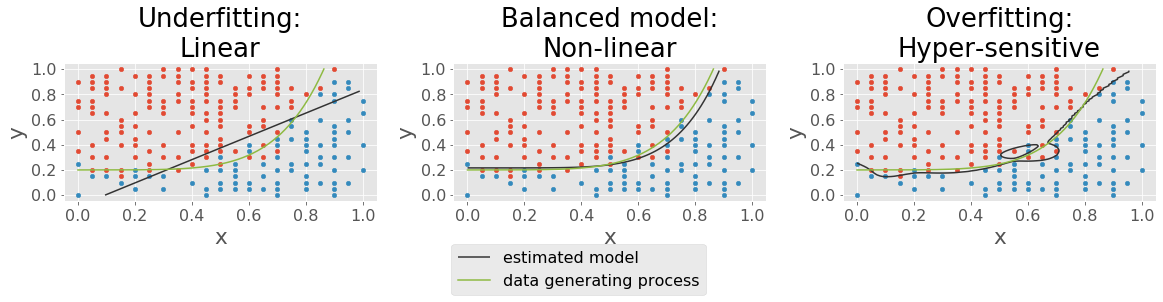

In [3]:
%run ./ML_plots.ipynb